In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import numpy as np
import pylab as plt

from scipy.optimize import least_squares
from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from grid import regridXYZ, regridXYZMasked
from parabolas import loadLeicaData, parabola
from plotting import surfacePlot, barChartPlot, scatterPlot
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly
from utils.utils import midPoint, getRollingStat, radialMask, makeGrid, gridLimits

In [73]:
def costParabolaSmallAngleZ(coef, x, y, z):
    """
    """
    
    xm = 50
    ym = 100
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    #c4 = coef[6]
    c5 = coef[6]
    #c6 = coef[8]
    xc = coef[7]
    yc = coef[8]
    
    crx = 1. - rx**2./2.
    srx = rx
    cry = 1. - ry**2./2.
    sry = ry
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xh = (xp - xc)/xm
    yh = (yp - yc)/ym
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    xh2 = np.power(xh, 2.)
    yh2 = np.power(yh, 2.)
    
    fp = 1./(4.*fl)*(xp2 + yp2)
    #z4 = c4*(xh2 - yh2)
    z5 = c5*(2.*xh2 + 2.*yh2 - 1.)
    #z6 = c6*xh*yh
    #z9 = c9*(3*xh2*yh + 3*yh2*yh - 2*yh)
    
    return fp + z5 - zp

def jacParabolaSmallAngleZ(coef, x, y, z):
    """
    """
    
    xm = 50.
    ym = 100.
    
    fl = coef[0]
    x0 = coef[1]
    y0 = coef[2]
    z0 = coef[3]
    rx = coef[4]
    ry = coef[5]
    #c4 = coef[6]
    c5 = coef[6]
    #c6 = coef[8]
    #c9 = coef[9]
    xc = coef[7]
    yc = coef[8]
    
    crx = 1. - rx**2./2.
    srx = rx
    cry = 1. - ry**2./2.
    sry = ry
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    dxdrx = y*ry - z*rx*ry
    
    dxdry = -x*ry + y*rx + z*crx
    
    dydrx = -y*rx - z
    
    dzdrx = y*cry - z*rx*cry
    
    dzdry = -x - y*rx*ry - z*crx*ry
    
    xh = (xp - xc)/xm
    yh = (yp - yc)/ym
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    xh2 = np.power(xh, 2.)
    yh2 = np.power(yh, 2.)
    
    dxhdx = -1./xm # Same for dxh/dxc or dxh/dx0
    dyhdy = -1./ym # Same for dyh/dyc or dyh/dy0
    
    dxhdrx = dxhdx*dxdrx
    
    dxhdry = dxhdx*dxdry
    
    dyhdrx = dyhdy*dydrx
    
    dyhdry = 0.
    
    dGdfl = -1./(4.*fl**2.)*(xp2 + yp2)
    
    dGdx0 = -1./(4.*fl)*2.*xp + c5*4*xh*dxhdx #c4*2.*xh*dxhdx + c5*4*xh*dxhdx + c6*yh*dxhdx #+ c9*6*xh*yh*dxhdx
    
    dGdy0 = -1./(4.*fl)*2.*yp - c5*4*yh*dyhdy #c4*2.*yh*dyhdy + c5*4*yh*dyhdy + c6*xh*dyhdy #+ c9*(3*xh2 + 9*yh2 - 2)*dyhdy
    
    dGdz0 = np.ones(len(z))
    
    dGdrx = 1./(4.*fl)*(2.*xp*dxdrx + 2.*yp*dydrx) + c5*(4*xh*dxhdrx + 4*yh*dyhdrx) #+ c4*(2.*xh*dxhdrx - 2.*yh*dyhdrx) + \
            #c5*(4*xh*dxhdrx + 4*yh*dyhdrx) \
            #+ c6*(yh*dxhdrx + xh*dyhdrx) #+ c9*(6*xh*yh*dxhdrx + 3*xh*dyhdrx + 9*yh2*dyhdrx - 2*dyhdrx) - dzdrx
    
    dGdry = 1./(4.*fl)*(2.*x*dxdry) + c5*4.*xh*dxhdry #c4*2.*xh*dxhdry + c5*4.*xh*dxhdry #+ c6*yh*dxhdry + c9*6*xh*yh*dxhdry - dzdry
    
    #dGdc4 = (xh2 - yh2)
    
    dGdc5 = 2.*xh2 + 2.*yh2 - 1.
    
    #dGdc6 = xh*yh
    
    #dGdc9 = 3.*xh2*yh + 3.*yh2*yh - 2.*yh
    
    dGdxc = c5*4.*xh*dxhdx #c4*2.*xh*dxhdx + c5*4.*xh*dxhdx + c6*yh*dxhdx #+ c9*6*xh*yh*dxhdx
    
    dGdyc = c5*4.*yh*dyhdy #-c4*2.*yh*dyhdy + c5*4*yh*dyhdy + c6*xh*dyhdy #+ c9*(3*xh2*dyhdy + 9*yh2*dyhdy - 2*dyhdy)
    
    return np.array([dGdfl, dGdx0, dGdy0, dGdz0, dGdrx, dGdry, dGdc5, dGdxc, dGdyc]).T# dGdc4, dGdc5, dGdc6, dGdxc, dGdyc]).T # dGdc9, dGdxc, dGdyc]).T

def costParabola(coef, x, y, z):
    """
    """
    
    fl = 60. #coef[0]
    x0 = coef[0]
    y0 = coef[1]
    z0 = coef[2]
    rx = coef[3]
    ry = coef[4]
    
    crx = np.cos(rx)
    srx = np.sin(rx)
    cry = np.cos(ry)
    sry = np.sin(ry)
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    
    fp = 1./(4.*fl)*(xp2 + yp2)
    
    return fp - zp


def jacParabola(coef, x, y, z):
    """
    """
    
    fl = 60. #coef[0]
    x0 = coef[0]
    y0 = coef[1]
    z0 = coef[2]
    rx = coef[3]
    ry = coef[4]
    
    crx = np.cos(rx)
    srx = np.sin(rx)
    cry = np.cos(ry)
    sry = np.sin(ry)
    
    xp = x*cry + y*srx*sry + z*crx*sry - x0
    yp = y*crx - z*srx - y0
    zp = -x*sry + y*srx*cry + z*crx*cry - z0
    
    xp2 = np.power(xp, 2.)
    yp2 = np.power(yp, 2.)
    
    dxdrx = y*crx*sry - z*srx*sry
    
    dxdry = -x*sry + y*srx*cry + z*crx*cry
    
    dydrx = -y*srx - z*crx
    
    dzdrx = y*crx*cry - z*srx*cry
    
    dzdry = -x*cry - y*srx*sry - z*crx*sry
    
    # Jacobian columns.
    #dGdfl = -1/(4*fl**2)*(xp2 + yp2)
    
    dGdx0 = -1/(4*fl)*2*xp
    
    dGdy0 = -1/(4*fl)*2*yp
    
    dGdz0 = np.ones(len(z))
    
    dGdrx = 1/(4*fl)*(2*xp*dxdrx + 2*yp*dydrx) - dzdrx
    
    dGdry = 1/(4*fl)*(2*x*dxdry) - dzdry
    
    return np.array([dGdx0, dGdy0, dGdz0, dGdrx, dGdry]).T

def parabolaFit(x, y, z, guess, method=costParabola, jac=jacParabola, 
                bounds=None,  max_nfev=10000, ftol=1e-12, xtol=1e-12, gtol=1e-12, 
                f_scale=1e-5, tr_solver=None, x_scale=None, verbose=False):
    
    # Set boundaries for the fit parameters.
    if bounds is None:
        inf = np.inf
        pi2 = 2*np.pi
        cmin = -inf
        cmax = inf
        fll = 60-1e-5
        flu = 60+1e-5
        if len(guess) == 12:
            b1 = [fll, -inf, -inf, -inf, -pi2, -pi2, cmin, cmin, cmin, cmin, -2, 48]
            b2 = [flu,  inf,  inf,  inf,  pi2,  pi2, cmax, cmax, cmax, cmax,  2, 52]
        else:
            b1 = [-inf, -inf, -inf, -pi2, -pi2]
            b2 = [inf,  inf,  inf,  pi2,  pi2]
            
            #b1 = [0., -inf, -inf, -inf, -pi2, -pi2]
            #b2 = [inf, inf,  inf,  inf,  pi2,  pi2]
            
        bounds = (b1, b2)
        
    # Robust fit: weights outliers outside of f_scale less
    loss = "soft_l1"
    
    if x_scale is None:
        xsr = np.deg2rad(0.001)
        xsz = 5e-5
        if len(guess) == 12:
            x_scale = [0.01, 0.01, 0.01, xsr, xsr, xsz, xsz, xsz, xsz, 0.1/50., 0.1/100.]
        else:
            x_scale = [0.01, 0.01, 0.01, xsr, xsr]
    
    if jac == None:
        jac = "3-point"
    
    args = (x.flatten(), y.flatten(), z.flatten())
    
    r = least_squares(method, guess, jac,
                      args=args,
                      bounds=bounds,
                      max_nfev=max_nfev,
                      loss=loss,
                      f_scale=f_scale,
                      ftol=ftol,
                      xtol=xtol,
                      gtol=gtol,
                      x_scale=x_scale,
                      tr_solver=tr_solver)
    return r


def removeParabolaFit(x, y, z, fit):
    xgdr, ygdr, zgdr = alignParabola(x, y, z, fit.x)
    zp = parabola(xgdr, ygdr, 60.)
    diff = zgdr - zp
    return xgdr, ygdr, diff


def alignParabola(x, y, z, fit):
    cor = np.hstack((-1*fit[:3],fit[3:5],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr


def parabolaFitIterations(x, y, z, guess=[0, 0, -50., 0, 0], bounds=None, iters=2, f_scale=1e-5):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        x_ = x[~mask]
        y_ = y[~mask]
        z_ = z[~mask]
        fit = parabolaFit(x_, y_, z_, guess, method=costParabola, jac=jacParabola, 
                          bounds=bounds, f_scale=f_scale)
        xdr, ydr, zdr = alignParabola(x, y, z, fit.x)
        zp = parabola(xdr, ydr, 60.)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = res.mask
        guess = fit.x
    
    return fit, mask

def initLeicaData(filename, n=512, rz=178):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(rz)])
    
    return xg, yg, zg

def guessRotations(zp, zr, n=512):
    """
    """
    idxf = int(n*3/4)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        zx0 = np.nanmean(sigma_clip(zr[n//2,0:40]))
        zxf = np.nanmean(sigma_clip(zr[n//2,idxf-20:idxf+20]))
        zp0 = np.nanmean(sigma_clip(zp[n//2,0:30]))
        zpf = np.nanmean(sigma_clip(zp[n//2,idxf-20:idxf+20]))
    
    print("z value at vertex: zp={}, zr={}".format(zp0, zx0))
    print("z value at center: zp={}, zr={}".format(zpf, zxf))
    
    rx0 = ((zpf - zp0) - (zxf - zx0))/75.
    print(rx0)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        zyc = np.nanmean(sigma_clip(zr[n//2-10:n//2+10,n//2]))
        zyl = np.nanmean(sigma_clip(zr[0:20,n//2]))
        zyr = np.nanmean(sigma_clip(zr[-20:,n//2]))
        zpc = np.nanmean(sigma_clip(zp[n//2-10:n//2+10,n//2]))
        zpl = np.nanmean(sigma_clip(zp[0:20,n//2]))
        zpr = np.nanmean(sigma_clip(zp[-20:,n//2]))
    
    print("z value at center: zp={}, zr={}".format(zpc, zyc))
    print("z value at left edge: zp={}, zr={}".format(zpl, zyl))
    print("z value at right edge: zp={}, zr={}".format(zpr, zyr))
    
    ry01 = ((zpl - zpc) - (zyl - zyc))/50.
    ry02 = ((zpr - zpc) - (zyr - zyc))/50.
    print(ry01, ry02)
    if ry01 > ry02:
        sign = 1.
    else:
        sign = -1.
    ry0 = sign*np.mean((abs(ry01), abs(ry02)))
    print(ry0)
    
    return rx0, ry0

In [72]:
3/4

0.75

In [113]:
n = 512
iters = 1
nZern = 36
iz = 13
izv = -534
zcoef = np.zeros(nZern)
zcoef[iz] = izv*1e-6
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
#refScan = "{0}/ref_average.ptx.csv".format(scanDir)
#sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486
#sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) # C4=-518
#sigScan = "{0}/2020_03_16_04:16:39.ptx.csv".format(scanDir) # C7=-545
sigScan = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir) # C13=-534
#sigScan = "{0}/450_2019-10-11_04:13:53.ptx.csv".format(scanDir) # C15=1080

<IPython.core.display.Javascript object>


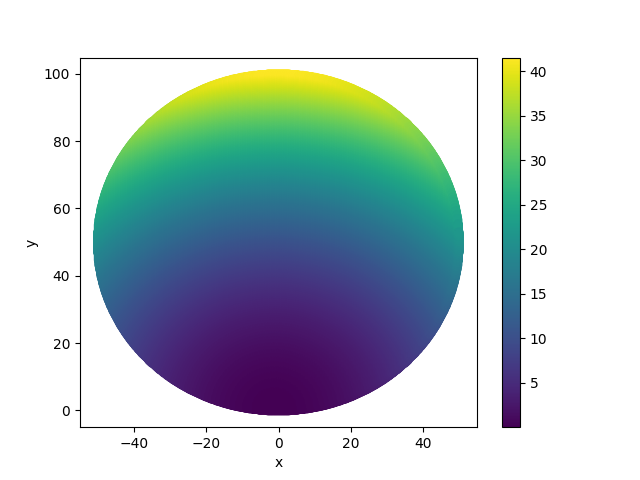

CPU times: user 628 ms, sys: 34.5 ms, total: 663 ms
Wall time: 616 ms


In [114]:
%%time
fl = 60.
xmin = -50
xmax = 50
ymin = 0.01
ymax = 100

dx = (xmax - xmin)/n
dy = (ymax - ymin)/n
xx, yy, zz = makeGrid(xmin, xmax, dx, ymin, ymax, dy)

zp = parabola(xx, yy, fl)
zp[~radialMask(xx, yy, 50)] = np.nan
zz += zp
scatterPlot(xx, yy, zz)

In [115]:
%%time
xr, yr, zr = initLeicaData(refScan, n=n, rz=178)
xs, ys, zs = initLeicaData(sigScan, n=n, rz=178)

CPU times: user 11.8 s, sys: 3.28 s, total: 15.1 s
Wall time: 9.25 s


<IPython.core.display.Javascript object>


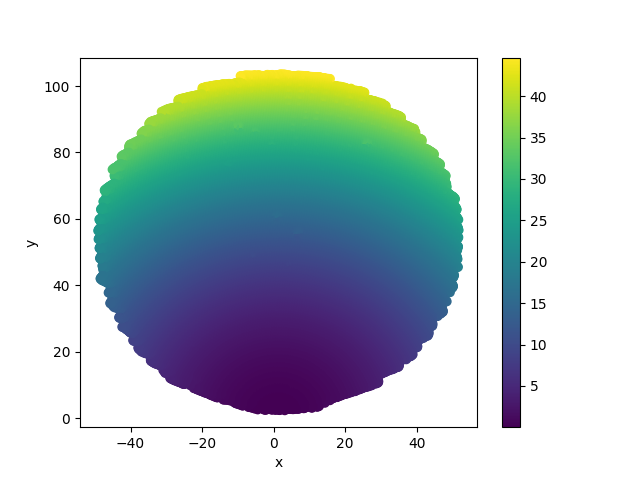

<IPython.core.display.Javascript object>


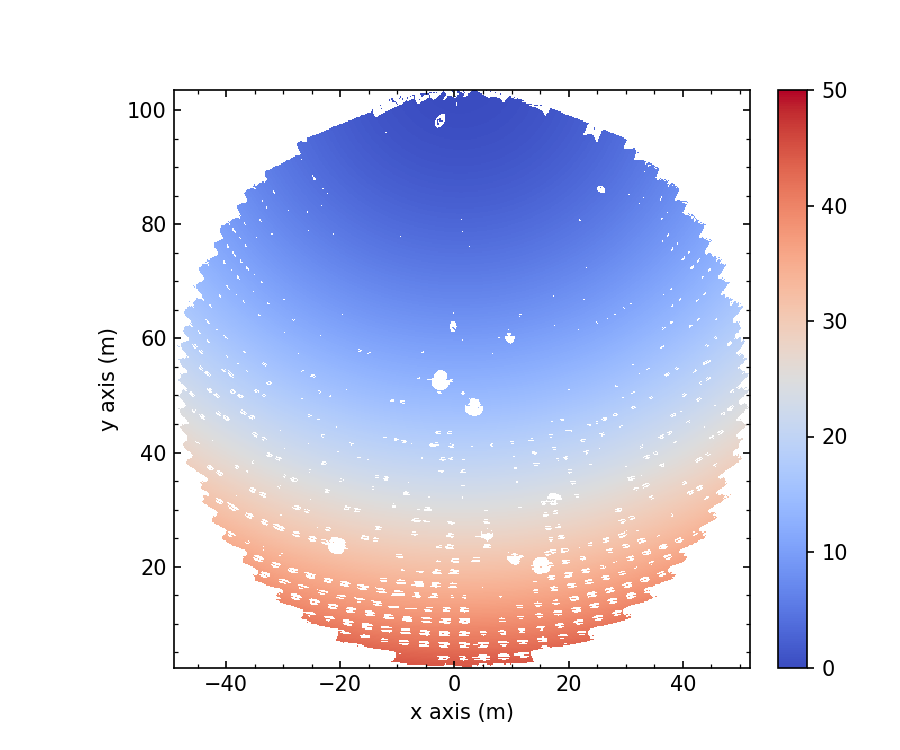

<IPython.core.display.Javascript object>


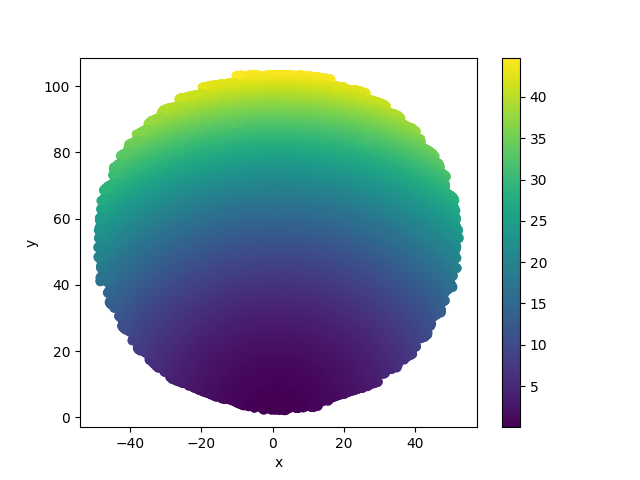

<IPython.core.display.Javascript object>


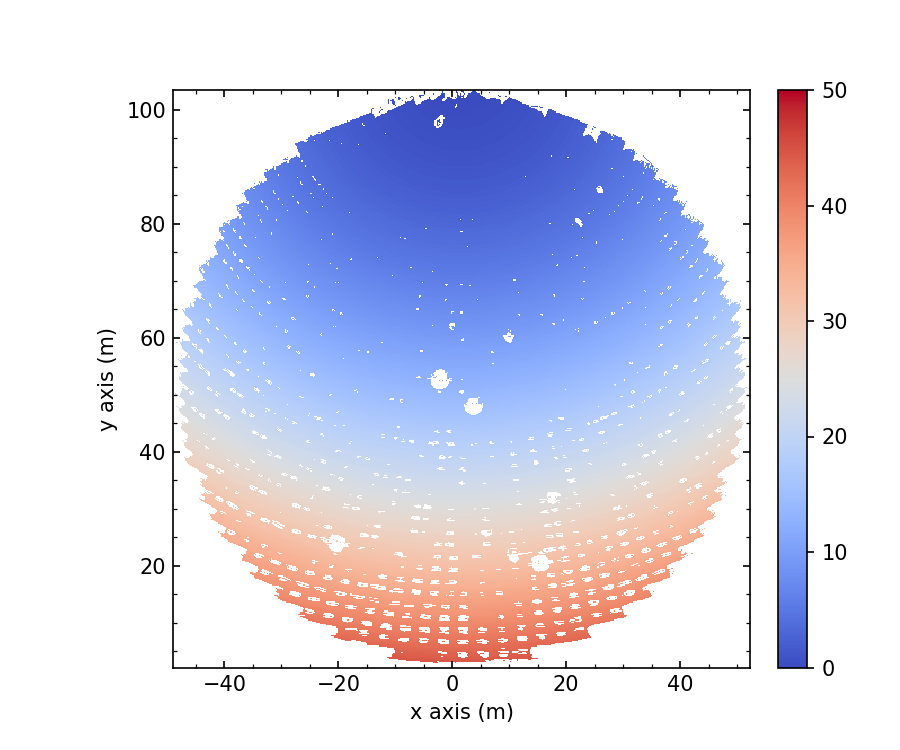

CPU times: user 3min 23s, sys: 3min 17s, total: 6min 41s
Wall time: 23.9 s


In [116]:
%%time
# Mask bad data.
rFit, rMask = parabolaFitIterations(xr, yr, zr, guess=[0, 0, -50., 0, 0], bounds=None, iters=2, f_scale=1e-5)
zrm = np.copy(zr)
zrm[rMask] = np.nan
sFit, sMask = parabolaFitIterations(xs, ys, zs, guess=[0, 0, -50., 0, 0], bounds=None, iters=2, f_scale=1e-5)
zsm = np.copy(zs)
zsm[sMask] = np.nan

# Fit a parabola and align the data.
rFit1 = parabolaFit(xr[~np.isnan(zrm)], yr[~np.isnan(zrm)], zr[~np.isnan(zrm)], 
                    [0, 0, -50, 0, 0], method=costParabola, jac=jacParabola,
                    bounds=None, max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4, 
                    verbose=False)
#xra, yra, zra = alignParabola(xr, yr, zrm, np.hstack((rFit1.x[:-3],[0,0,0])))
#xra, yra, zra = alignParabola(xr, yr, zrm, np.hstack((rFit1.x[:2],[0],rFit1.x[3:])))
xra, yra, zra = alignParabola(xr, yr, zrm, rFit1.x)
scatterPlot(xra, yra, zra)
surfacePlot(xra, yra, zra.T, vMin=0, vMax=50, midPoint=25)

sFit1 = parabolaFit(xs[~np.isnan(zsm)], ys[~np.isnan(zsm)], zs[~np.isnan(zsm)], 
                    [0, 0, -50, 0, 0], method=costParabola, jac=jacParabola,
                    bounds=None, max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4, 
                    verbose=False)
#xsa, ysa, zsa = alignParabola(xs, ys, zsm, np.hstack((sFit1.x[:-3],[0,0,0])))
#xsa, ysa, zsa = alignParabola(xs, ys, zsm, np.hstack((sFit1.x[:2],[0],sFit1.x[3:])))
xsa, ysa, zsa = alignParabola(xs, ys, zsm, sFit1.x)
scatterPlot(xsa, ysa, zsa)
surfacePlot(xsa, ysa, zsa.T, vMin=0, vMax=50, midPoint=25)

In [118]:
rFit1.x, sFit1.x, np.mean((rFit1.x, sFit1.x), axis=0)

(array([ 2.45219007e+00, -1.00731228e+00, -4.93032179e+01,  2.20185920e-01,
        -5.07553374e-03]),
 array([ 2.45356154e+00, -1.00743457e+00, -4.93032486e+01,  2.20173949e-01,
        -5.05265511e-03]),
 array([ 2.45287581e+00, -1.00737343e+00, -4.93032333e+01,  2.20179934e-01,
        -5.06409443e-03]))

In [120]:
fit1 = np.array([2e+00, -1., -4.9e+01,  2e-01, -5.0e-03])
fit1 = np.mean((rFit1.x, sFit1.x), axis=0)
xra, yra, zra = alignParabola(xr, yr, zrm, fit1)
xsa, ysa, zsa = alignParabola(xs, ys, zsm, fit1)

In [121]:
%%time
xmin, xmax = gridLimits(xsa, xra)
ymin, ymax = gridLimits(ysa, yra)
xrg, yrg, zrg = regridXYZMasked(xra, yra, np.ma.masked_invalid(zra), n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsg, ysg, zsg = regridXYZMasked(xsa, ysa, np.ma.masked_invalid(zsa), n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 16.6 s, sys: 4.31 s, total: 20.9 s
Wall time: 12.6 s


<IPython.core.display.Javascript object>


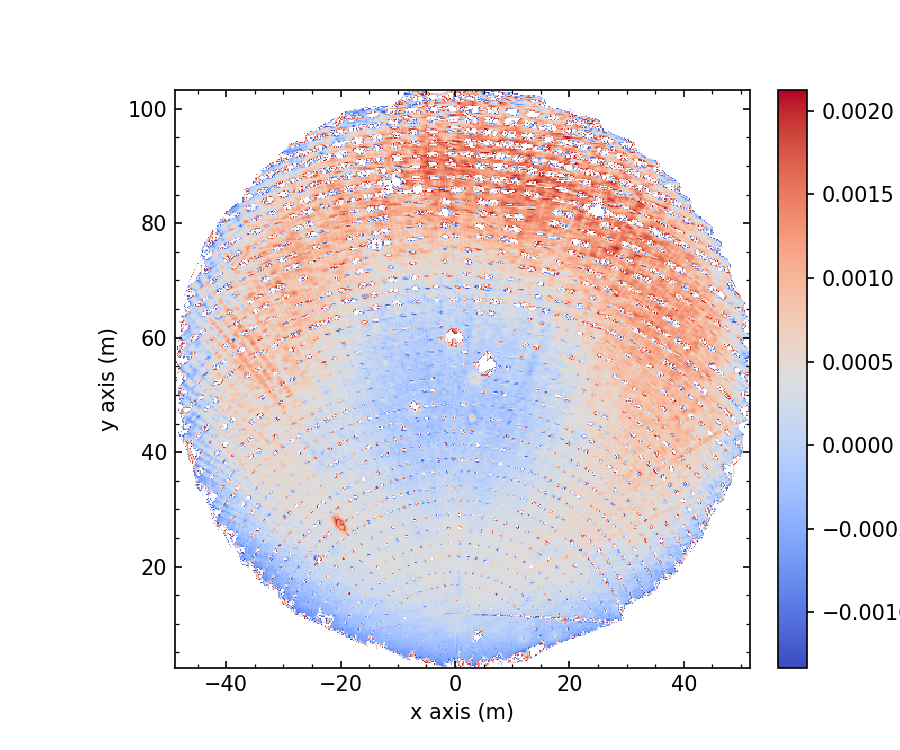

<IPython.core.display.Javascript object>


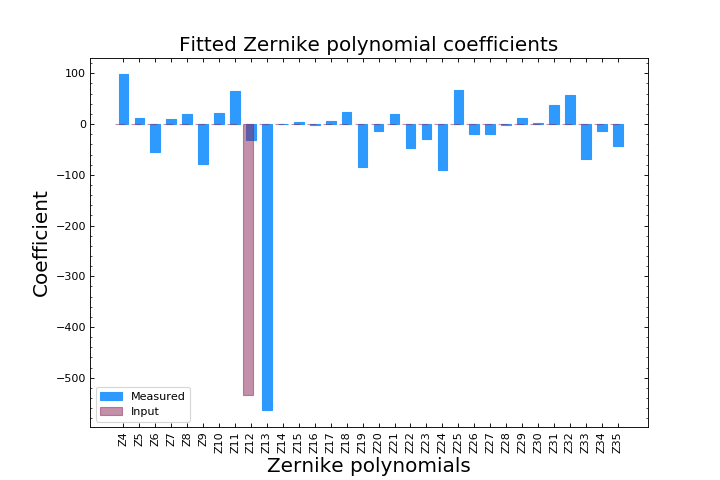

[-9.79328809e-05 -1.17118090e-05  5.53303384e-05 -9.29941971e-06
 -1.99926001e-05  7.82775816e-05 -2.26799760e-05 -6.44719023e-05
 -5.03185794e-04  5.64276192e-04 -7.71791718e-07 -4.76978197e-06
  1.64846535e-06 -5.43642938e-06 -2.40306704e-05  8.47738195e-05
  1.31319856e-05 -2.02661628e-05  4.68047375e-05  2.91208013e-05
  9.11046909e-05 -6.69405116e-05  1.92767635e-05  1.96874116e-05
  1.68591954e-06 -1.20598647e-05 -2.64966024e-06 -3.77309484e-05
 -5.79470198e-05  6.79511396e-05  1.39031905e-05  4.35496106e-05]
CPU times: user 1.36 s, sys: 28.1 ms, total: 1.39 s
Wall time: 1.38 s


In [122]:
%%time
diff = (zsg - zrg)
diff_ = sigma_clip(diff)
vmin = np.nanmin(diff_)
vmax = np.nanmax(diff_)
midpoint = (vmin + vmax)/2.
surfacePlot(xrg, yrg, diff_.T, vMin=vmin, vMax=vmax, midPoint=midpoint)
zfit = getZernikeCoeffs(diff_.filled(0).T[:,::-1], 36, norm='active-surface')
barChartPlot(np.arange(4,36), zfit[4:36]*1e6, expected=zcoef[4:36]*1e6)
print(zcoef[4:36] - zfit[4:36])
#zpoly_ = zernikePoly(xrg, yrg, midPoint(xrg), midPoint(yrg), zfit[:4])
#diff__ = sigma_clip(diff_ - zpoly_)
#surfacePlot(xrg, yrg, diff__.T, vMin=-2e-4, vMax=2e-4)
#diff_ = np.ma.masked_invalid(diff)
#zfit_ = getZernikeCoeffs(diff__.filled(0), 36, norm='active-surface')
#barChartPlot(np.arange(4,36), zfit_[4:36]*1e6, expected=zcoef[4:36]*1e6)
#print(zcoef[4:36] - zfit_[4:36])
#zcoef[4:36] - zfit_[4:36]

In [90]:
xr[10,n//2], xs[10,n//2]

(52.70801982396594, 53.12689407271113)

In [91]:
xra[10,n//2], xsa[10,n//2]

(50.397104346575574, 50.81401307389588)

In [92]:
yra[10,n//2], ysa[10,n//2], 

(50.42391613322037, 50.32556043372082)

In [170]:
print(xra[10,n//2], xsa[10,n//2], xra[10,n//2]-xsa[10,n//2])
print(yra[10,n//2], ysa[10,n//2], yra[10,n//2]-ysa[10,n//2])

50.39665213264728 50.813959553882654 -0.4173074212353711
50.41916729872313 50.32074719497387 0.09842010374926247


In [172]:
51.42099875124685-51.31715013939521, 50.39665213264728-50.813959553882654

(0.10384861185163885, -0.4173074212353711)

In [174]:
np.unravel_index(np.nanargmin(zra), zra.shape),np.unravel_index(np.nanargmin(zsa), zsa.shape)

((257, 511), (258, 510))

In [53]:
idx_min_r = np.unravel_index(np.nanargmin(zr), zr.shape)
idx_min_s = np.unravel_index(np.nanargmin(zs), zs.shape)
xs[idx_min_s]-xr[idx_min_r],ys[idx_min_s]-yr[idx_min_r]

(-0.12508688838735038, -0.1934906654844557)

In [55]:
idx_min_ra = np.unravel_index(np.nanargmin(zra), zra.shape)
idx_min_sa = np.unravel_index(np.nanargmin(zsa), zsa.shape)
xsa[idx_min_sa]-xra[idx_min_ra],ysa[idx_min_sa]-yra[idx_min_ra]

(0.07233361950069073, -0.3281947075118117)

In [182]:
print(xra[10,n//2], xsa[10,n//2], xra[10,n//2]-xsa[10,n//2])
print(yra[10,n//2], ysa[10,n//2], yra[10,n//2]-ysa[10,n//2])

50.39665213264728 50.813959553882654 -0.4173074212353711
51.42099875124685 51.31715013939521 0.10384861185163885


<IPython.core.display.Javascript object>


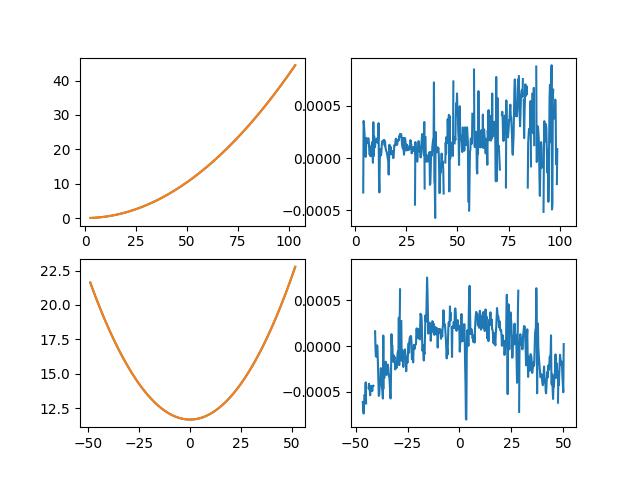

In [24]:
# When the result is bad.
plt.figure()

plt.subplot(221)
plt.plot(yrg[n//2], zrg[n//2])
plt.plot(ysg[n//2], zsg[n//2])

plt.subplot(222)
plt.plot(yrg[n//2], sigma_clip(zsg[n//2] - zrg[n//2]))

plt.subplot(223)
plt.plot(xrg[:,n//2], zrg[:,n//2])
plt.plot(xsg[:,n//2], zsg[:,n//2])

plt.subplot(224)
plt.plot(xrg[:,n//2], sigma_clip(zsg[:,n//2] - zrg[:,n//2]))

<IPython.core.display.Javascript object>


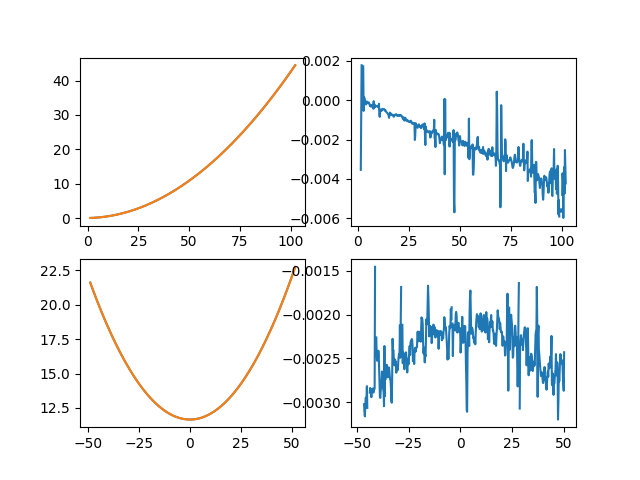

In [188]:
plt.figure()

plt.subplot(221)
plt.plot(yrg[n//2], zrg[n//2])
plt.plot(ysg[n//2], zsg[n//2])

plt.subplot(222)
plt.plot(yrg[n//2], sigma_clip(zsg[n//2] - zrg[n//2]))

plt.subplot(223)
plt.plot(xrg[:,n//2], zrg[:,n//2])
plt.plot(xsg[:,n//2], zsg[:,n//2])

plt.subplot(224)
plt.plot(xrg[:,n//2], sigma_clip(zsg[:,n//2] - zrg[:,n//2]))